In [48]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [49]:
df=pd.read_excel('1613615-Stock_Price_data_set.xlsx')
# df.set_index("Date", inplace = True)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100.0
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800.0
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500.0
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700.0
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900.0
...,...,...,...,...,...,...,...
1004,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500.0
1005,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300.0
1006,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000.0
1007,2022-02-03,421.440002,429.260010,404.279999,405.600006,405.600006,9905200.0


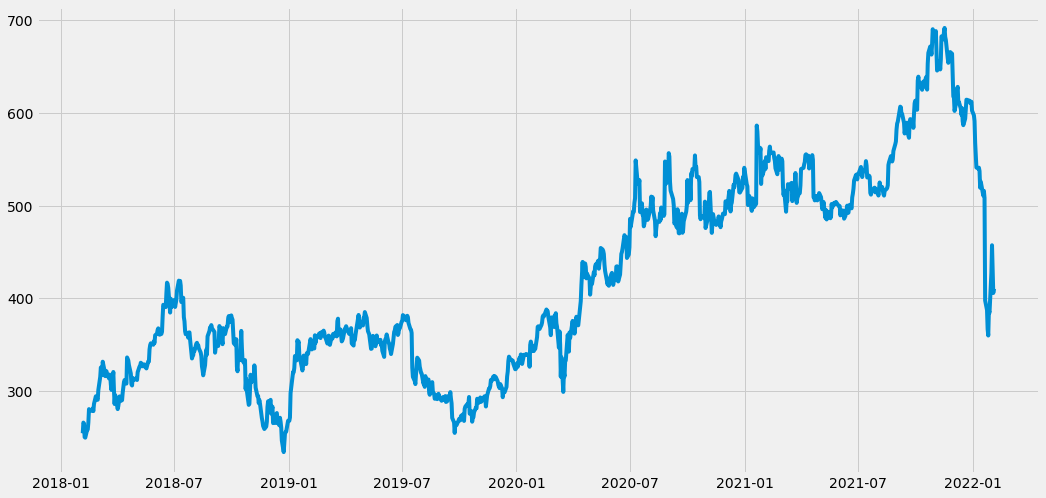

In [50]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [51]:
data=df.filter(['Close'])
dataset=data.values
training_data_len=math.ceil(len(dataset)*.8)
training_data_len

808

In [52]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

In [53]:
train_data = scaled_data[0:training_data_len,:]
x_train=[]
y_train=[]
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [54]:
x_train,y_train=np.array(x_train),np.array(y_train)

x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(748, 60, 1)

## Build and train the LSTM model:

In [55]:
lstm_model=Sequential()
lstm_model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
lstm_model.add(LSTM(50,return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

In [56]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train,y_train,epochs=1,batch_size=1)

748/748 [==============================] - 24s 28ms/step - loss: 0.0034


In [57]:
test_data = scaled_data[training_data_len-60:,:]
x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [58]:
x_test=np.array(x_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [59]:
predicted=lstm_model.predict(x_test)
predicted=scaler.inverse_transform(predicted)
# Y_test=scaler.inverse_transform(y_test)

In [60]:
rmse = np.sqrt(np.mean(predicted-y_test)**2)
rmse

20.00908408787119

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


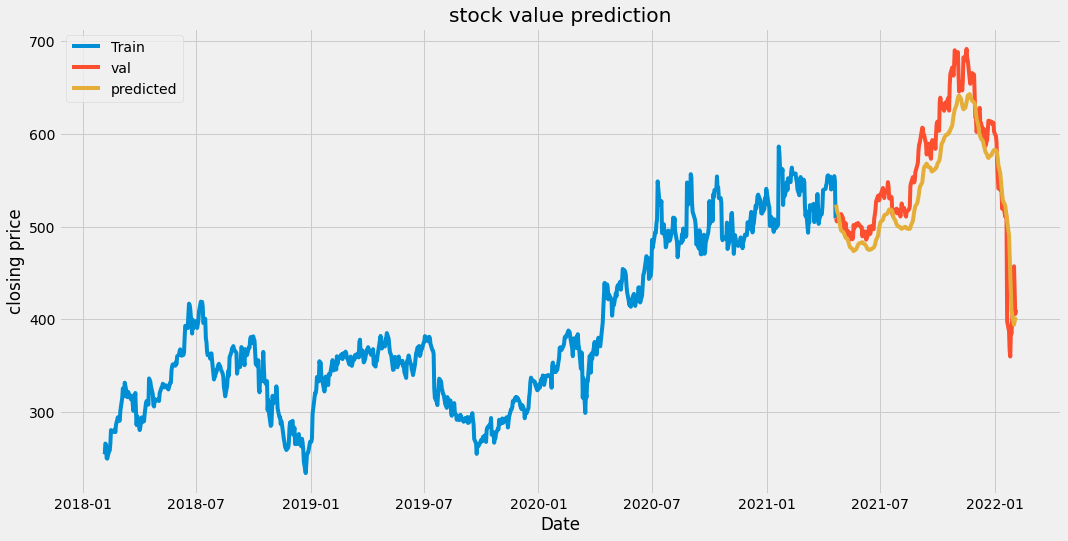

In [63]:
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Predictions']=predicted
plt.figure(figsize=(16,8))
plt.title('stock value prediction')
plt.xlabel('Date')
plt.ylabel('closing price')
plt.plot(train["Close"])
plt.plot(valid[['Close',"Predictions"]])
plt.legend(['Train','val','predicted'])
plt.show()